In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, random, cv2, glob, pydicom
from sklearn.model_selection import StratifiedKFold

In [3]:
df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv');
print(df.shape)
df

(585, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [4]:
df.MGMT_value.value_counts()

1    307
0    278
Name: MGMT_value, dtype: int64

In [5]:
# def read_dicom_xray(path):
#     data = pydicom.read_file(path).pixel_array
#     data = data - np.min(data)
#     data = data / np.max(data)
#     data = (data * 255).astype(np.uint8)
#     return data


In [6]:
# train_sample_path="../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"

In [7]:
# def visualize_sample(brats2lid, mgmt_value, slice_i, types=("FLAIR", "T1w", "T1wCE", "T2w")):
#     plt.figure(figsize=(16,5))
#     patient_path= os.path.join(
#         train_sample_path,str(brats21id).zfill(5))
#     for i, t in enumerate(types, 1):
#         t_path = sorted(
#             glob.glob(os.path.join(patient_path,t,"*")), key=lambda x: int(x[:-4].split("-")[-1]))
#         data = read_dicom_xray(t_path[int(len(t_paths)*slice_i)])
#         plt.subplot(1,4,i)
#         plt.imshow(data, cmp="gray")
#         plt.title(f"{t}", fontsize=18)
#         plt.axis("off")
#     plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
#     plt.show()
    
    
# for i in random.sample(range(df.shape[0]), 10):
#     visualize_sample(df.iloc[i]["BraTS21ID"], df.iloc[i]["MGMT_value"], slice_i=0.5)

In [8]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [9]:
train_sample_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"

In [10]:
def visualize_sample(
    brats21id, 
    slice_i,
    mgmt_value,
    types=("FLAIR", "T1w", "T1wCE", "T2w")
):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        data = load_dicom(t_paths[int(len(t_paths) * slice_i)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

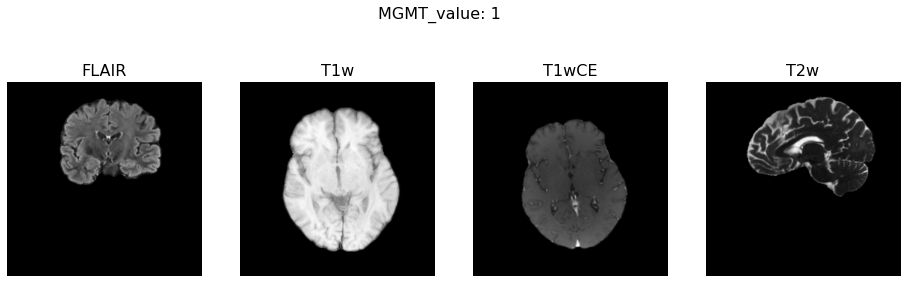

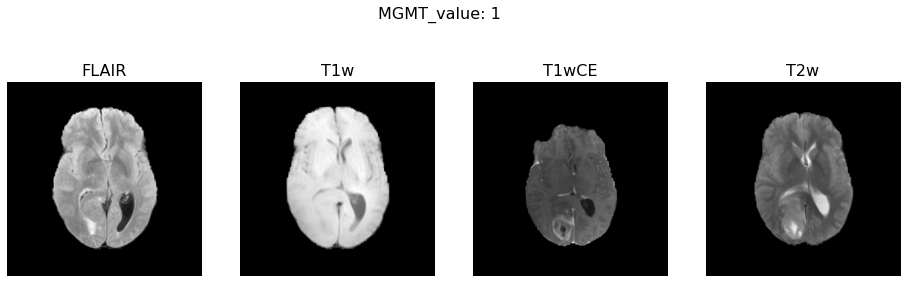

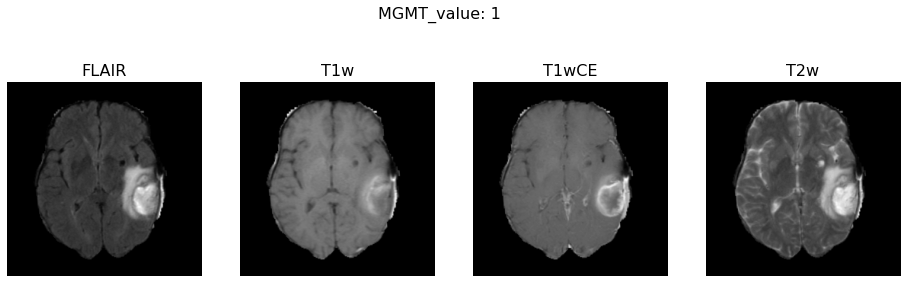

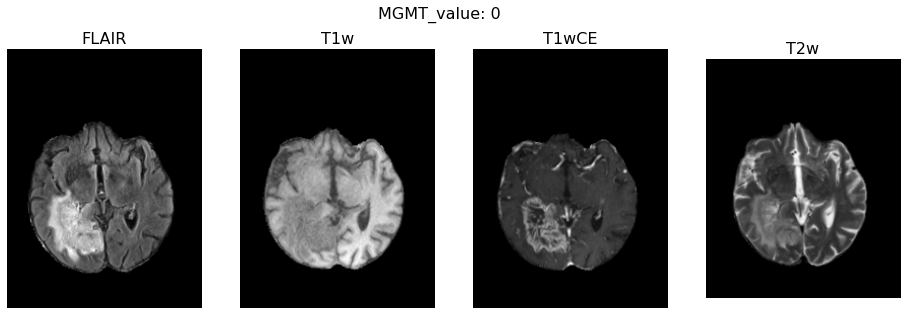

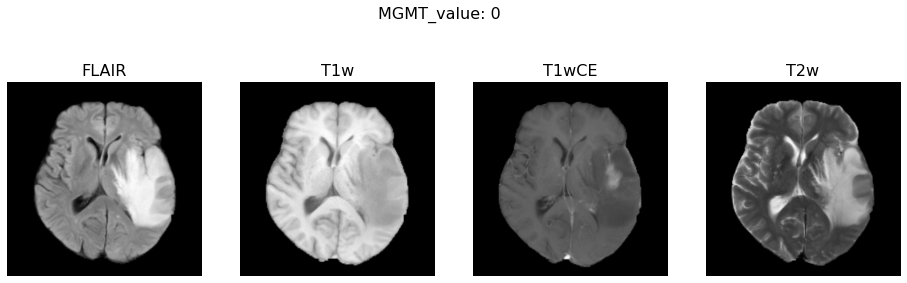

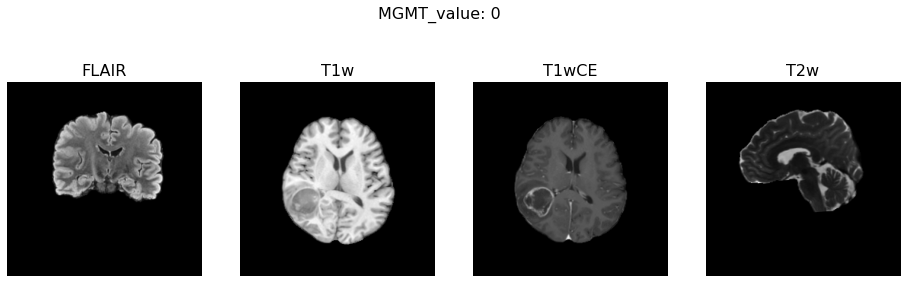

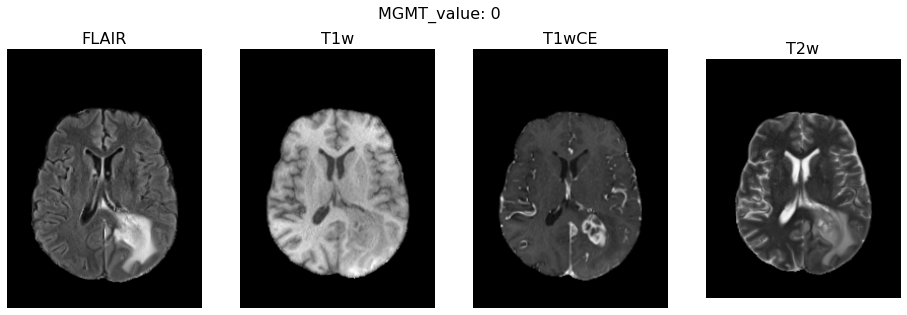

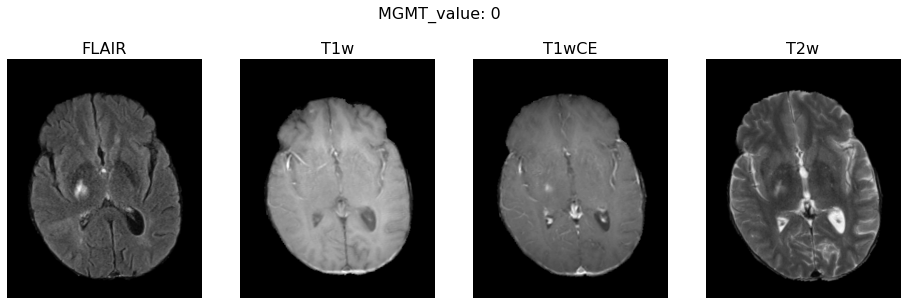

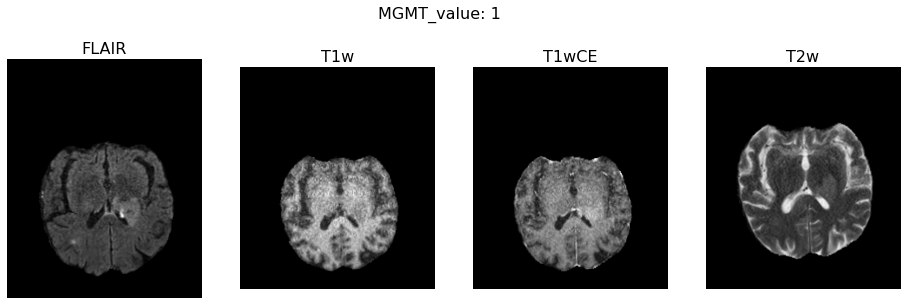

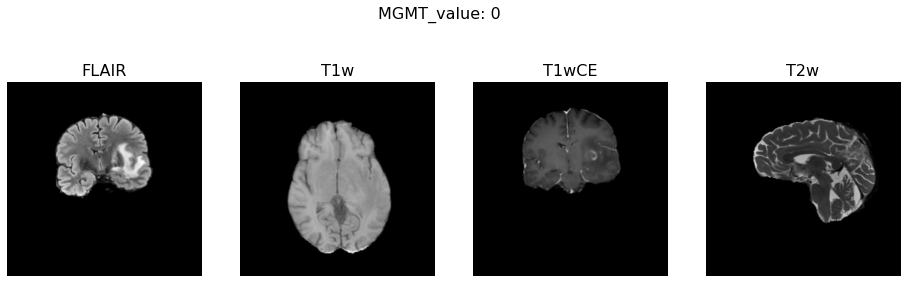

In [11]:
for i in random.sample(range(df.shape[0]), 10):
    _brats21id = df.iloc[i]["BraTS21ID"]
    _mgmt_value = df.iloc[i]["MGMT_value"]
    visualize_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5)

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for index, (train_index, val_index) in enumerate(skf.split(X=df.index, 
                                                           y=df.MGMT_value)):
    df.loc[val_index, 'fold'] = index
    
print(df.groupby(['fold', df.MGMT_value]).size())

fold  MGMT_value
0.0   0             55
      1             62
1.0   0             55
      1             62
2.0   0             56
      1             61
3.0   0             56
      1             61
4.0   0             56
      1             61
dtype: int64


In [13]:
import tensorflow as tf

In [17]:
input_height = 256
input_width = 256
input_depth = 20
batch_size = 3
fold = 0

class BrainTumorGenerator(tf.keras.utils.Sequence):
    def __init__(self, dicom_path, data):
        self.data = data
        self.dicom_path= dicom_path
        self.label = self.data['MGMT_value']

    def __len__(self):
        return self.data['BraTS21ID'].shape[0]
    
    def __getitem__(self, index):
        patient_ids = f"{self.dicom_path}/{str(self.data['BraTS21ID'][index]).zfill(5)}/"

        channel = []
        for t in ("FLAIR", "T1w", "T1wCE", "T2w"):
            t_path =  sorted(
                glob.glob(os.path.join(patient_ids, t, "*")),
                key=lambda x: int(x[:-4].split("-")[-1]),
            )

            K = 10

            strt_idx = (len(t_path)//2) - (K//2)
            end_idx = (len(t_path)//2) + (K//2)

            r= t_path[strt_idx:end_idx:2]

            threshold = 0
            for i in r:
                image = self.read_dicom_xray(i)
                temp_image = image

                rows = np.where(np.max(temp_image, 0)> threshold)[0]
                if rows.size:
                    cols = np.where(np.max(temp_image, 1)> threshold)[0]
                    image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] +1]

                else :
                    image = image[:1 , :1]

                channel.append(cv2.resize(image, (input_height, input_width)))
        
        return np.array(channel).T, self.label.iloc[index,]

    def read_dicom_xray(self, path):
        data = pydicom.read_file(path).pixel_array
        data = data - np.min(data)
        data = data/ np.max(data)
        data = (data * 255).astype(np.uint8)
        return data

In [19]:
def fold_generator(fold):
    train_labels = df[df.fold != fold].reset_index(drop=True)
    val_labels = df[df.fold == fold].reset_index(drop=True)
    
    return (
        BrainTumorGenerator(train_sample_path, train_labels),
        BrainTumorGenerator(train_sample_path, val_labels)
    )

train_gen, val_gen = fold_generator(fold)

(3, 256, 256, 20, 1) (3,)


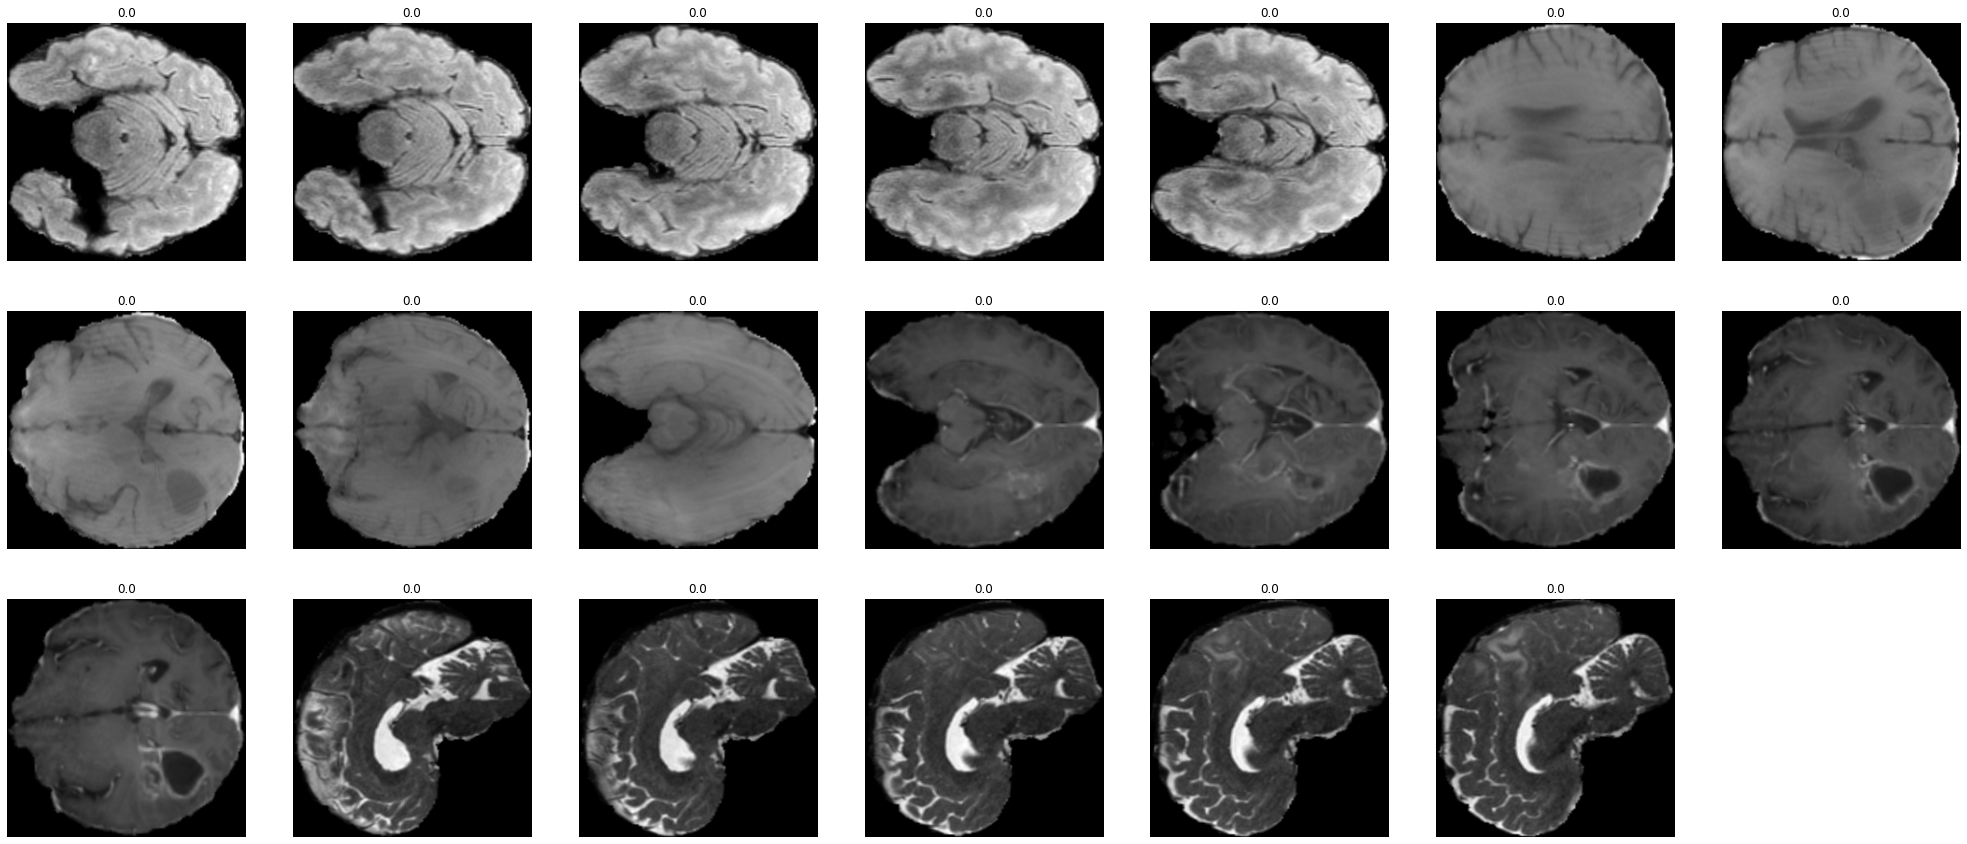

In [20]:
train_data = tf.data.Dataset.from_generator(
    lambda: map(tuple, train_gen),
    (tf.float32, tf.float32),
    (
        tf.TensorShape([input_height, input_width, input_depth]),
        tf.TensorShape([]),
    ),
)


def volume_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label


from tensorflow.keras.layers.experimental.preprocessing import (CenterCrop, RandomFlip,
                                                                RandomRotation, RandomZoom)
augmentation_layers = tf.keras.Sequential(
    [
        CenterCrop(input_height, input_width),
        RandomFlip("vertical")
    ]
)


AUTO = tf.data.AUTOTUNE
train_generator = (
    train_data.shuffle(batch_size * 10, seed=42)
    .batch(batch_size, drop_remainder=True)
    .map(lambda x, y: (augmentation_layers(x), y), num_parallel_calls=AUTO)
    .map(volume_preprocessing, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)


# visualization 
x, y = next(iter(train_generator))
print(x.shape, y.shape)  
plt.figure(figsize=(35, 15))
for i in range(20):
    plt.subplot(3, 7, i + 1)
    plt.imshow(x[1 ,:, :, i], cmap="gray")
    plt.axis("off")
    plt.title(y[1].numpy())

(3, 256, 256, 20, 1) (3,)


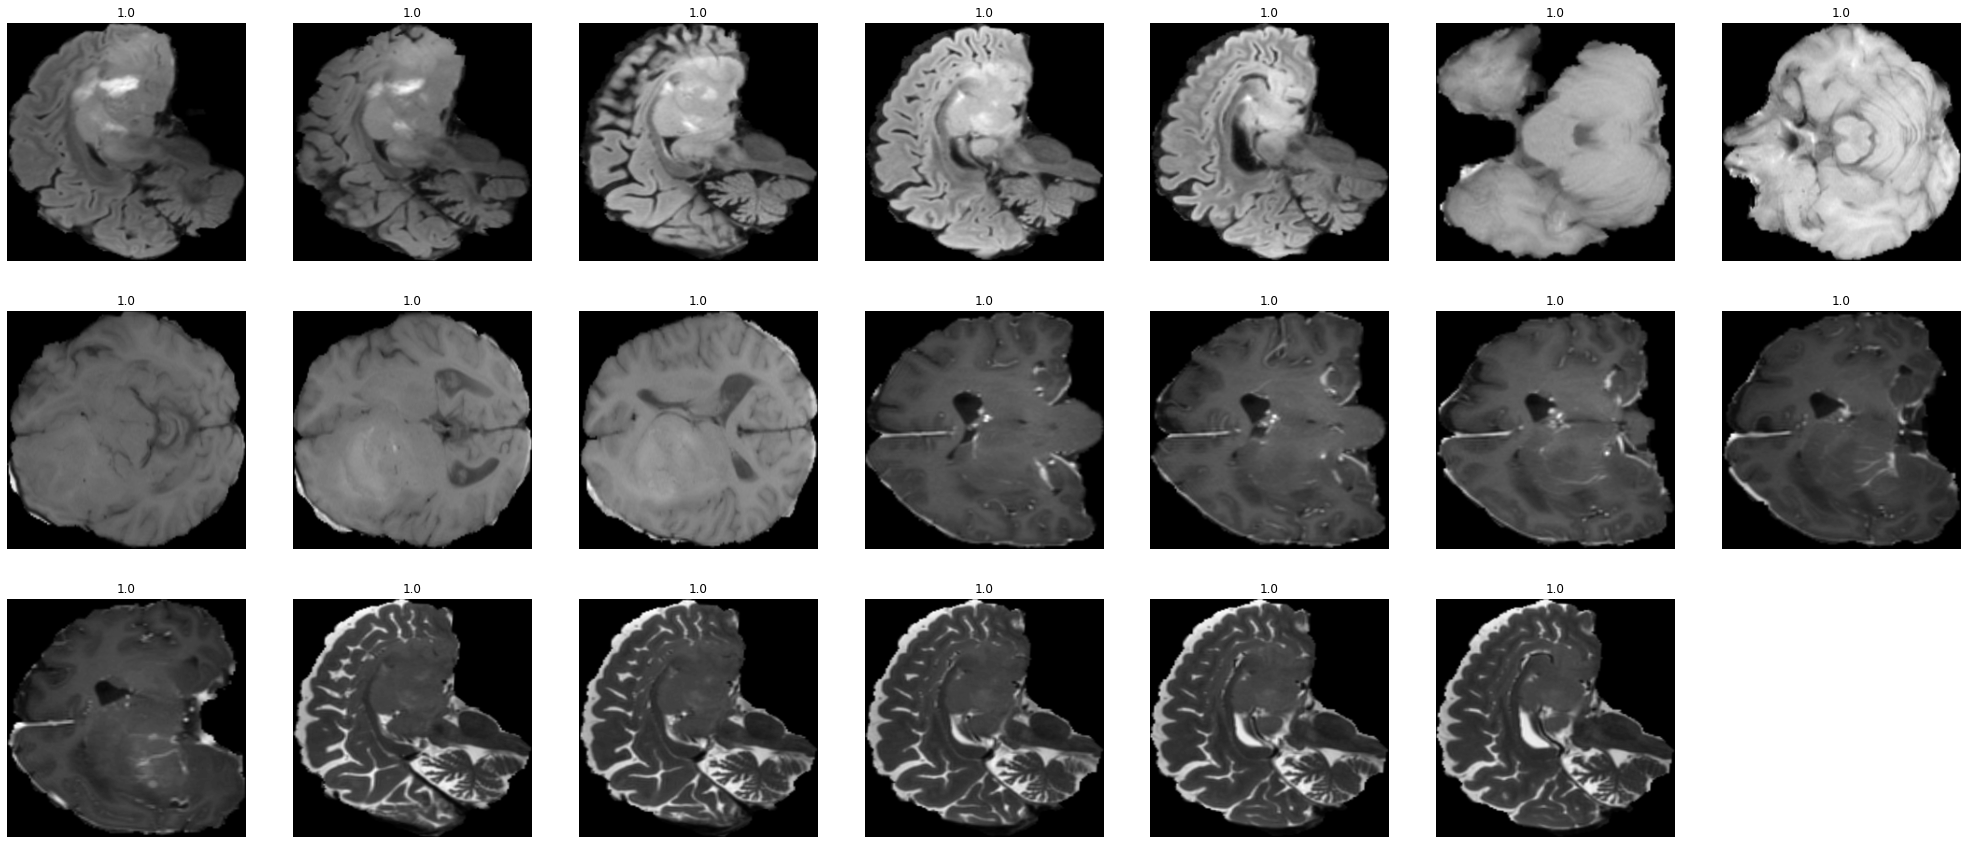

In [31]:
val_data = tf.data.Dataset.from_generator(
    lambda: map(tuple, val_gen),
    (tf.float32, tf.float32),
    (
        tf.TensorShape([input_height, input_width, input_depth]),
        tf.TensorShape([]),
    ),
)

def volume_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label



validation_generator = (
    val_data.batch(batch_size, drop_remainder=True)
    .map(volume_preprocessing)
    .prefetch(AUTO)
)

x, y = next(iter(validation_generator))
print(x.shape, y.shape)  
plt.figure(figsize=(35, 15))
for i in range(20):
    plt.subplot(3, 7, i + 1)
    plt.imshow(x[0 ,:, :, i], cmap="gray")
    plt.axis("off")
    plt.title(y[0].numpy())

In [32]:
import tensorflow as tf 
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

class Conv3DBatchNorm(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size, padding, strides):
        super(Conv3DBatchNorm, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # parameters 
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size 
        self.padding = padding 
        self.strides = strides 

        # layers
        self.conv = tf.keras.layers.Conv3D(self.nb_filters, self.kernel_size, 
                                           self.strides, self.padding)
        self.bn   = tf.keras.layers.BatchNormalization()
        
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        return tf.nn.relu(x)
    
    def get_config(self):
        return {
            'nb_filters': self.nb_filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'strides': self.strides
        }




In [33]:
class Inception3DModule(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size1x1, kernel_size3x3):
        super(Inception3DModule, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # params 
        self.nb_filters = nb_filters
        self.kernel_size1x1 = kernel_size1x1
        self.kernel_size3x3 = kernel_size3x3

        # layers 
        self.conv1 = Conv3DBatchNorm(self.nb_filters, kernel_size=self.kernel_size1x1,
                                     strides=1, padding='same')
        self.conv2 = Conv3DBatchNorm(self.nb_filters, kernel_size=self.kernel_size3x3, 
                                     strides=1, padding='same')
        self.cat   = tf.keras.layers.Concatenate()

    def call(self, input_tensor, training=False):
        x_1x1 = self.conv1(input_tensor)
        x_3x3 = self.conv2(input_tensor)
        x = self.cat([x_1x1, x_3x3])
        return tf.nn.relu(x) 

    def get_config(self):
        return {
            'nb_filters': self.nb_filters,
            'kernel_size1x1': self.kernel_size1x1,
            'kernel_size3x3': self.kernel_size3x3
        }

In [34]:
class Identity3DBlock(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size, padding, strides, shortcut = False):
        super(Identity3DBlock, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # params 
        self.shortcut = shortcut 
        self.nb_filters = nb_filters 
        self.kernel_size = kernel_size 
        self.padding = padding 
        self.strides = strides 
        
        # layers 
        self.conv1 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.conv2 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.conv3 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.inception = Inception3DModule(self.nb_filters, 
                                           kernel_size1x1 = (1,1,1),
                                           kernel_size3x3 = (3,3,3))
    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        if self.shortcut:
            srtct = self.inception(input_tensor)
            srtct = self.conv3(srtct)
            x = Dropout(0.3)(x)
            x = Add()([x, srtct])
            return tf.nn.relu(x)
        else:
            x = Add()([x, input_tensor])
            return tf.nn.relu(x)
        
    def get_config(self):
        return {
            'shortcut': self.shortcut,
            'nb_filters': self.nb_filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'strides': self.strides,
        }

In [35]:
def InceptionResNet3D(width=128, height=128, depth=32, num_cls=1):
    inpt = Input((width, height, depth, 1), name='input3D')
    x = ZeroPadding3D((1, 1, 1))(inpt)

    
    x = Conv3DBatchNorm(nb_filters=16, kernel_size=(3, 3, 3), 
                        strides=1, padding='valid')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=1)(x)

    x = Identity3DBlock(nb_filters=32, kernel_size=(3, 3, 3), 
                        padding='same', strides=1, shortcut=True)(x)
    x = Identity3DBlock(nb_filters=32, kernel_size=(3, 3, 3), 
                        padding='same', strides=1)(x)

    x = AveragePooling3D(pool_size=(2, 2, 2))(x)
    x = GlobalAveragePooling3D()(tf.nn.relu(x))
    x = Dense(num_cls, activation='sigmoid')(x)

    model = Model(inputs=inpt, outputs=x)
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input3D (InputLayer)         [(None, 256, 256, 20, 1)] 0         
_________________________________________________________________
zero_padding3d (ZeroPadding3 (None, 258, 258, 22, 1)   0         
_________________________________________________________________
conv3d_batch_norm (Conv3DBat (None, 256, 256, 20, 16)  512       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 255, 255, 19, 16)  0         
_________________________________________________________________
identity3d_block (Identity3D (None, 255, 255, 19, 32)  111904    
_________________________________________________________________
identity3d_block_1 (Identity (None, 255, 255, 19, 32)  55616     
_________________________________________________________________
average_pooling3d (AveragePo (None, 127, 127, 9, 32)   0     

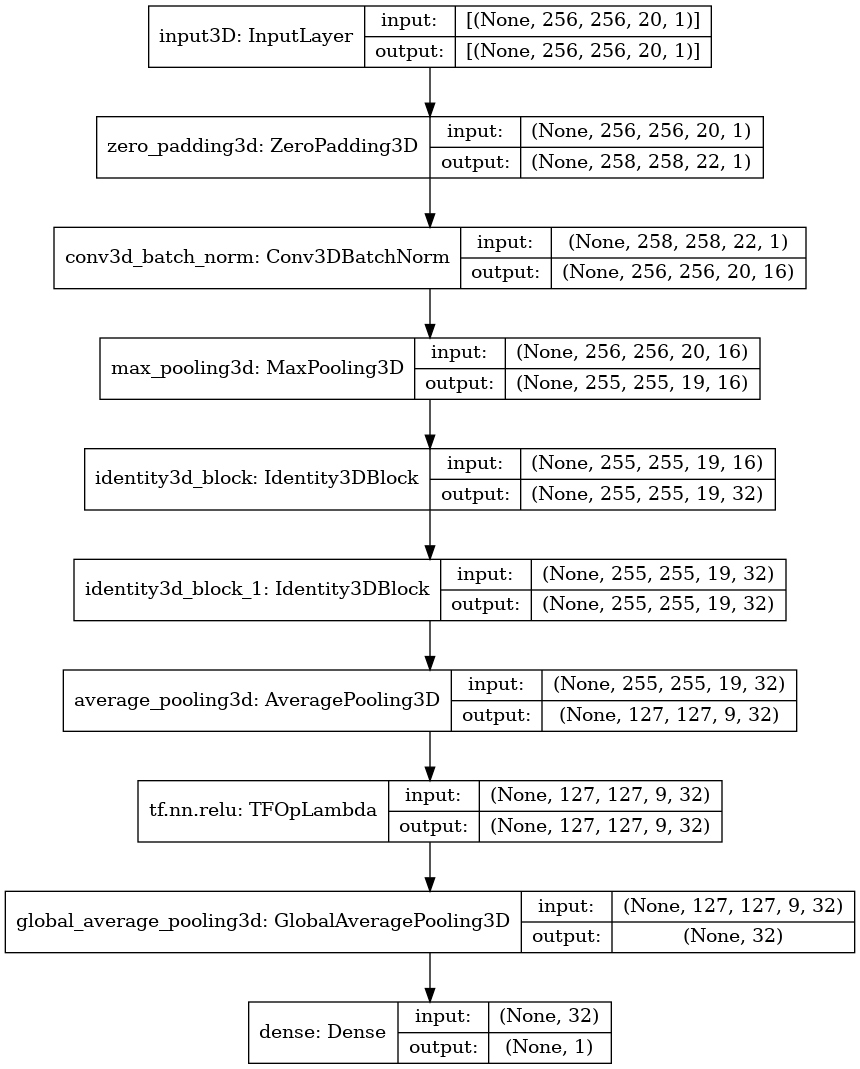

In [36]:

tf.keras.backend.clear_session()
model = InceptionResNet3D(width=input_width, height=input_height, depth=input_depth, num_cls=1)
print(model.summary())
plot_model(model, show_shapes=True)

In [37]:
class BrainTumorModel3D(tf.keras.Model):
    def __init__(self, model):
        super(BrainTumorModel3D, self).__init__()
        self.model = model
    
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            loss = self.compiled_loss(labels, predictions)
            
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, labels = data
        predictions = self.model(images, training=False)
        loss = self.compiled_loss(labels, predictions, 
                                  regularization_losses=[self.reg_l2_loss()])
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, *args, **kwargs):
        return self.model(inputs)
    
    def reg_l2_loss(self, weight_decay = 1e-5):
        return weight_decay * tf.add_n([
            tf.nn.l2_loss(v)
            for v in self.model.trainable_variables
        ])
    
    def build_graph(self):
        x = Input(shape=((input_height, input_width, input_depth,1)))
        return Model(inputs=[x], outputs=self.call(x))

In [38]:
model = BrainTumorModel3D(InceptionResNet3D(width=input_width, height=input_height, 
                                            depth=input_depth, num_cls=1))
model(tf.ones((1, input_height, input_width, input_depth, 1)));

In [39]:
from tensorflow import keras 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead


model.compile(
    loss="binary_crossentropy",
    optimizer= SGD(learning_rate=0.01),
    metrics=[tf.keras.metrics.AUC()],
)


checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", monitor='val_auc', 
    mode='max', save_best_only=True
)


epochs = 10
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb], verbose=2 
)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


156/156 - 416s - loss: 0.7185 - auc: 0.5186 - val_loss: 0.7177 - val_auc: 0.5446
Epoch 2/10
156/156 - 384s - loss: 0.7032 - auc: 0.5311 - val_loss: 0.7035 - val_auc: 0.4906
Epoch 3/10
156/156 - 383s - loss: 0.7008 - auc: 0.5364 - val_loss: 0.7390 - val_auc: 0.5345
Epoch 4/10
156/156 - 384s - loss: 0.6951 - auc: 0.5564 - val_loss: 0.7137 - val_auc: 0.5364
Epoch 5/10
156/156 - 382s - loss: 0.6956 - auc: 0.5432 - val_loss: 0.7415 - val_auc: 0.5331
Epoch 6/10
156/156 - 382s - loss: 0.6980 - auc: 0.5203 - val_loss: 0.7922 - val_auc: 0.5471
Epoch 7/10
156/156 - 382s - loss: 0.6942 - auc: 0.5525 - val_loss: 1.0345 - val_auc: 0.5214
Epoch 8/10
156/156 - 381s - loss: 0.6992 - auc: 0.5334 - val_loss: 0.6994 - val_auc: 0.5419
Epoch 9/10
156/156 - 382s - loss: 0.6944 - auc: 0.5498 - val_loss: 0.7775 - val_auc: 0.5270
Epoch 10/10
156/156 - 381s - loss: 0.6934 - auc: 0.5507 - val_loss: 0.7699 - val_auc: 0.5271
